# <span style="color:#0080FF;">Udacity - Data Analyst Nanodegree </span>
## <span style="color:#B45F04;">Project 5: Identify Fraud from Enron Email</span>
### <span style="color:black;">Created by: Layne Newhouse</span>
### <span style="color:#6E6E6E;">Submitted: December X, 2016</span>

### *Background Information*

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will be playing detective by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. Labels will be provided via a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. Features for the dataset include a subset of financial features as well as email features as follows:


<b>Financial Features:</b> ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

<b>Email Features:</b> ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

<b>POI Label:</b> [‘poi’] (boolean, represented as integer)

### *Project Tasks*

1. Select features
2. Identify and remove outliers
3. Create new features
4. Analyze a variety of classifiers
5. Tune a chosen classifier to achieve > 0.3 precision and recall
6. Dump the classifier, dataset and feature list

### *Getting Started*

The list below is a consolidation of the imported functions and modules that were used throughout the project. Having these imports in one place as opposed to scattered across the code makes it cleaner and easier to read. 

In [1]:
#standard modules used throughout
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import warnings
import pickle
import time
import sys
#plots display in notebook
%matplotlib inline
#import math(scipy stats), and dictionary modules
from collections import defaultdict
from scipy.stats import randint
from scipy import stats
#import course provided functions
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
#import sklearn classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import additional sklearn modules 
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,\
                                    RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#supresses warnings about cross_validation being depreciated in favour of
#model_selection, introduced version 0.18 removed 0.20
warnings.simplefilter(action = "ignore", category = FutureWarning)

C:\Users\layne\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### *Understanding the Dataset*

This section looks at important characteristics of the dataset such as total number of data points, allocation across classes (POI/non-POI), number of features used, and features with many missing values. In additional, any outliers in the dataset will be identified and removed if deemed necessary.

In [2]:
#load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)

In [3]:
#total number of data points
def total_people(dataset):
    people = len(dataset)
    print "Total Number of People in the Dataset:", people
    return people
    
people = total_people(enron_data)

Total Number of People in the Dataset: 146


In [4]:
#allocation across classes (POI/non-POI)
def total_classes(dataset):
    poi = 0
    people = 0
    for person in dataset:
        people += 1
        if dataset[person]["poi"]==1:
            poi += 1
    poi_pct = 100*float(poi)/people
    print "Number of POIs in the Dataset:",poi,"(%0.2f%%)"%poi_pct
    print "Number of Non-POIs in the Dataset:",people-poi,\
                                                "(%0.2f%%)"%(100-poi_pct)
    return poi

poi = total_classes(enron_data)

Number of POIs in the Dataset: 18 (12.33%)
Number of Non-POIs in the Dataset: 128 (87.67%)


By analyzing the data with the snippets of code above, we can start to understand what our dataset looks like and what each of the of the features have to offer in terms of the number and percentage of datapoints (or people) with missing values for each individual feature.

Before removing any 'bad data' or outliers from our data, we see that we have 146 data points (people) in the dataset. Of those people, 18 (12.3%) are labeled as Persons of Interest (POIs) and 128 (87.7%) are labeled as Non-POIs. With such a small dataset and a small pool of data points being classified as 'true' for being a POI we must be careful with the removal of outliers as well as the way in which we train and test our classifiers. Such precaussions would be to not remove POIs unless abosolutely needed as well as using the entire dataset to train our classifier and then validate it using a stratified shuffle as opposed to a simple test/train split. (We will go into further detail of this in the following sections).

In [5]:
#number of features used
def total_features(dataset):
    features = []
    for key, value in dataset.iteritems() :
        for item in value:
            if item not in features:
                features.append(item)
    print "Number of Features Available:", len(features)
    return features
    
features = total_features(enron_data)
print "\nList of Features:", features

Number of Features Available: 21

List of Features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


Missing Features [Total, POI]:
defaultdict(<type 'list'>, {'salary': [51, 1], 'to_messages': [60, 4], 'deferral_payments': [107, 13], 'total_payments': [21, 0], 'loan_advances': [142, 17], 'bonus': [64, 2], 'email_address': [35, 0], 'restricted_stock_deferred': [128, 18], 'total_stock_value': [20, 0], 'shared_receipt_with_poi': [60, 4], 'long_term_incentive': [80, 6], 'exercised_stock_options': [44, 6], 'from_messages': [60, 4], 'other': [53, 0], 'from_poi_to_this_person': [60, 4], 'from_this_person_to_poi': [60, 4], 'poi': [0, 0], 'deferred_income': [97, 7], 'expenses': [51, 0], 'restricted_stock': [36, 1], 'director_fees': [129, 18]})

Missing Features as a Percentile [Total %, POI %]:
defaultdict(<type 'list'>, {'salary': ['34.9', '5.6'], 'to_messages': ['41.1', '22.2'], 'deferral_payments': ['73.3', '72.2'], 'total_payments': ['14.4', '0.0'], 'loan_advances': ['97.3', '94.4'], 'bonus': ['43.8', '11.1'], 'email_address': ['24.0', '0.0'], 'restricted_stock_deferred': ['87.7', '100.0'

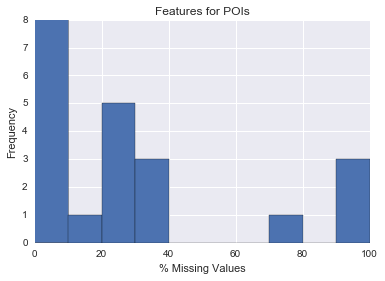

In [6]:
#indentifying features with missing values
missing_features = defaultdict(list)
mf_percent = defaultdict(list)
mf_poi = []
for feature in features:
    missing_features[feature] = [0,0]
    mf_percent[feature] = [0,0]
    
for person in enron_data:
    for feature in features:
        if enron_data[person][feature] == 'NaN':
            missing_features[feature][0] += 1
            if enron_data[person]["poi"] == 1:
                missing_features[feature][1] += 1
                
for feature in missing_features:
    x = (100*missing_features[feature][0] / float(people))
    mf_percent[feature][0] = "%0.1f" % x
    y = (100*missing_features[feature][1] / float(poi))
    mf_percent[feature][1] = "%0.1f" % y
    mf_poi.append(y)
    
print "Missing Features [Total, POI]:\n", missing_features
print "\nMissing Features as a Percentile [Total %, POI %]:\n", mf_percent

plt.hist(mf_poi)
plt.title("Features for POIs")
plt.xlabel("% Missing Values")
plt.ylabel("Frequency")
plt.show()

As seen from above, there are 21 features avaialbe in the dataset, one of them being the POI label. By printing out the labels we can verify that they are indeed legitimate labels (in terms of the strings themselves). Next we tallied the number of 'NaN's in each label and compared them against the POI allocations. Here we observe that there are a number of features that have a significant amount of missing values for POIs. By creating a quick plot we can see that there are a group of three features with over 90% of the POIs missing values for and one feature with over 70% of the POIs missing values for. Since we only have 18 POIs to begin with, features in which many POI's don't have values for will not provide a lot of information on how to identify the POIs and will likely confuse our classifiers since any NaN's will be later converted into zeros. Therefore the following features will be removed from the analysis:

In [7]:
#removing features
removed_features = []
for feature in mf_percent:
    if float(mf_percent[feature][1]) > 70:
        removed_features.append(feature)
for person in enron_data:
    for feature in removed_features:
        enron_data[person].pop(feature, 0)
print "Removed Features:\n", removed_features

Removed Features:
['deferral_payments', 'loan_advances', 'restricted_stock_deferred', 'director_fees']


Next we will do a similar missing value analysis but this time on the data points instead of the features. This will allow us to identify any people that aren't providing a significant amount of information and then choose whether or not we would like to exclude them from the dataset.

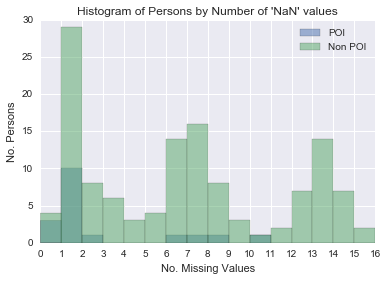

In [8]:
#indentifying persons with missing values
names = []
zeros = []
pois = []
for person in enron_data:
    zero = 0
    pois.append(enron_data[person]['poi'])
    for key in enron_data[person]:
        value = enron_data[person][key]
        if value == (0 or 'NaN'):
            zero += 1
    names.append(person)
    zeros.append(zero)
#seperating zeros with POI allocation
poi_true = []
poi_false = []
for i in range(0, len(zeros)):
    if pois[i] == True:
        poi_true.append(zeros[i])
    else:
        poi_false.append(zeros[i])
#histogram of persons by number of NaN values, seperated by POI allocation
binwidth = 1
bins= range(min(poi_false), max(poi_false) + binwidth, binwidth)
plt.hist(poi_true, bins, alpha=0.5, label='POI')
plt.hist(poi_false, bins, alpha=0.5, label='Non POI')
plt.legend(loc='upper right')
plt.xticks(np.arange(min(poi_false), max(poi_false)+1, 1.0))
plt.title('Histogram of Persons by Number of \'NaN\' values')
plt.xlabel("No. Missing Values")
plt.ylabel("No. Persons")
plt.show()

The problem, as stated above, with having too many NaNs they will eventually all converted into zeros and then processed by the classifiers. Thus if there was a large group of people that were all classified as Non POI and had many missing feature values the classifiers could wrongly associate these missing feature values, or zeros, as being a trait of Non-POIs.

The visualization above shows us the amount of people that have x features missing from the total feature set, x being denoted on the x-axis. Since we do not want to remove any POIs from the dataset, we will remove all datapoints that have 11 or more missing feature values.

In [9]:
removed_names = []
for i in range(0, len(names)):
    if zeros[i] >= 11:
        enron_data.pop(names[i], 0)
        removed_names.append(names[i])

print "No. Datapoints Removed:", len(removed_names), "\n\n", removed_names

No. Datapoints Removed: 32 

['LOWRY CHARLES P', 'WALTERS GARETH W', 'CHAN RONNIE', 'BELFER ROBERT', 'WODRASKA JOHN', 'URQUHART JOHN A', 'WHALEY DAVID A', 'MENDELSOHN JOHN', 'CLINE KENNETH W', 'WAKEHAM JOHN', 'DUNCAN JOHN H', 'LEMAISTRE CHARLES', 'WROBEL BRUCE', 'MEYER JEROME J', 'SCRIMSHAW MATTHEW', 'GATHMANN WILLIAM D', 'GILLIS JOHN', 'LOCKHART EUGENE E', 'PEREIRA PAULO V. FERRAZ', 'BLAKE JR. NORMAN P', 'PRENTICE JAMES', 'GRAY RODNEY', 'THE TRAVEL AGENCY IN THE PARK', 'NOLES JAMES L', 'CHRISTODOULOU DIOMEDES', 'JAEDICKE ROBERT', 'WINOKUR JR. HERBERT S', 'BADUM JAMES P', 'YEAP SOON', 'FUGH JOHN L', 'SAVAGE FRANK', 'GRAMM WENDY L']


After printing and reading the removed datapoints I had noticed that "THE TRAVEL AGENCY IN THE PARK" had made it into the dataset. When looking back at the insider pay pdf, I could confirm that this point existed and was located at the very end of the document. Depending on the size and type of dataset, different measures could be taken to identify dirty data including a character search, word count or looking at the number of legitamate feature values as we did above.

Now that we have removed datapoints without insignificant feature values, we will take a look at datapoints with feature values that are too high, i.e. outliers. Plotting variables against eachother will allow us to visually detect any abnormalities within the data.

In [10]:
def scatter(dataset, features):
    data = featureFormat(dataset, features)
    for pair in data:
        x = pair[0]
        y = pair[1]
        plt.scatter(x,y)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()    

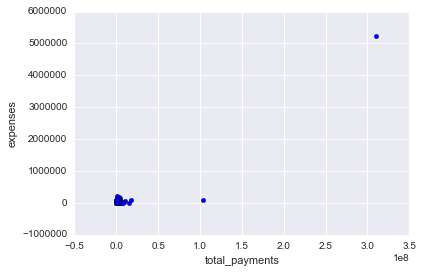

In [11]:
#plotting salary vs bonus
features = ['total_payments', 'expenses']
scatter(enron_data, features)

From this graph we can visually identify an outlier that is far beyond any other datapoint in the dataset. The next step would be to identify who or what this point actually is. 

In [12]:
#searching for the outlier
def find_largest_value(dataset, feature_name):
    outlier_name = ""
    largest_value = 0
    for key, value in enron_data.iteritems():
        inside_dict = value
        for k, v in inside_dict.iteritems():
            if (k == feature_name) & (v != 'NaN'):
                if v > largest_value:
                    largest_value = v
                    outlier_name = key
    print outlier_name, largest_value

In [13]:
find_largest_value(enron_data, 'total_payments')

TOTAL 309886585


Looking back at the insider pay pdf, it is easy to see how "TOTAL" could have gotten into the dataset and is another good example of dirty data that needs to be removed. After removing "TOTAL" I will re-create the scatterplot and add histograms to each feature. 

In [14]:
enron_data.pop("TOTAL", 0);

In [15]:
def scatter_hist(dataset, features):
    data = featureFormat(enron_data, features)
    df = pd.DataFrame(data, columns=[features[0], features[1]])
    sns.jointplot(x=features[0], y=features[1], data=df)

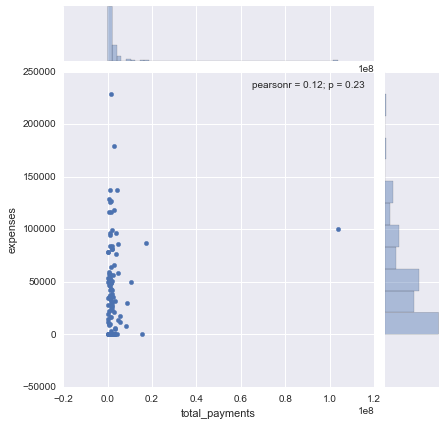

In [16]:
scatter_hist(enron_data, features)

In [17]:
find_largest_value(enron_data, 'total_payments')

LAY KENNETH L 103559793


Having removed the "TOTAL" datapoint there are still two visible issues with the plot above. 

The first issue is that there is another significant outlier in the total_payments section, after searching for the person with the highest value we find that it is Kenneth L Lay. Since Kenneth Lay is in fact a POI it is hard to say whether or not we should remove him from the dataset. After testing the classifiers in another notebook proved that removing him actually does increase the results of most the classifiers. We can justify this result since Ken Lay was the CEO of Enron and thus when we are looking for other employees that were a part of his scandel, the amount of money these employees are making would not likely surmount to the amount of money that Mr. Lay was making.

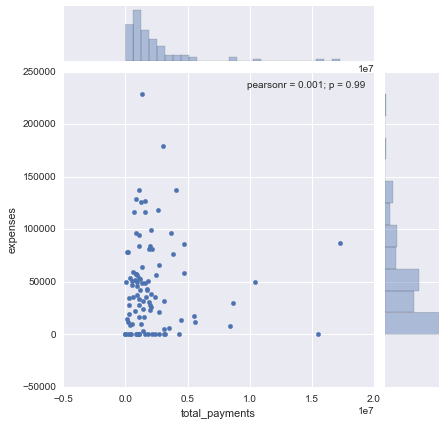

In [18]:
enron_data.pop("LAY KENNETH L", 0)
scatter_hist(enron_data, features)

The second issue we see is that the distribution of the finance data is left skewed and thus by doing a log10 transformation on the data we can attempt to normalize the distribution. To begin to transform the financial features a pandas dataframe should be create from the enron_data dictionary and then split into two seperate dataframes, one for financial features and the other for email features.

In [57]:
#original financial features
f_features = ['salary','deferral_payments','total_payments','loan_advances',
              'bonus','restricted_stock_deferred','deferred_income', 
              'total_stock_value','expenses','exercised_stock_options','other', 
              'long_term_incentive','restricted_stock','director_fees']
#original email features
e_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
              'from_this_person_to_poi', 'shared_receipt_with_poi']

#removing features from original list if in removed_features
f_features = [feat for feat in f_features if feat not in removed_features]
e_features = [feat for feat in e_features if feat not in removed_features]

enron_df = pd.DataFrame.from_dict(enron_data, "index")

financial_df = enron_df[f_features]
financial_df = financial_df.replace("NaN", 0)

email_df = enron_df[e_features]
email_df = email_df.replace("NaN", 0)

At this point, prior to taking the log10 transformation of the financial features, we can use seaborn's 'PairGrid' function to create a scatter plot of each two variable pair, as well as a histogram of each variables distribution. This will help give us insight on whether we should in fact transform all of the financial features or just select features.

In [20]:
#calculates pearson correlation (r)
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
def pair_grid(dataframe, filename):
    g = sns.PairGrid(dataframe)
    g.map_offdiag(plt.scatter)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(corrfunc)
    g.savefig(filename)

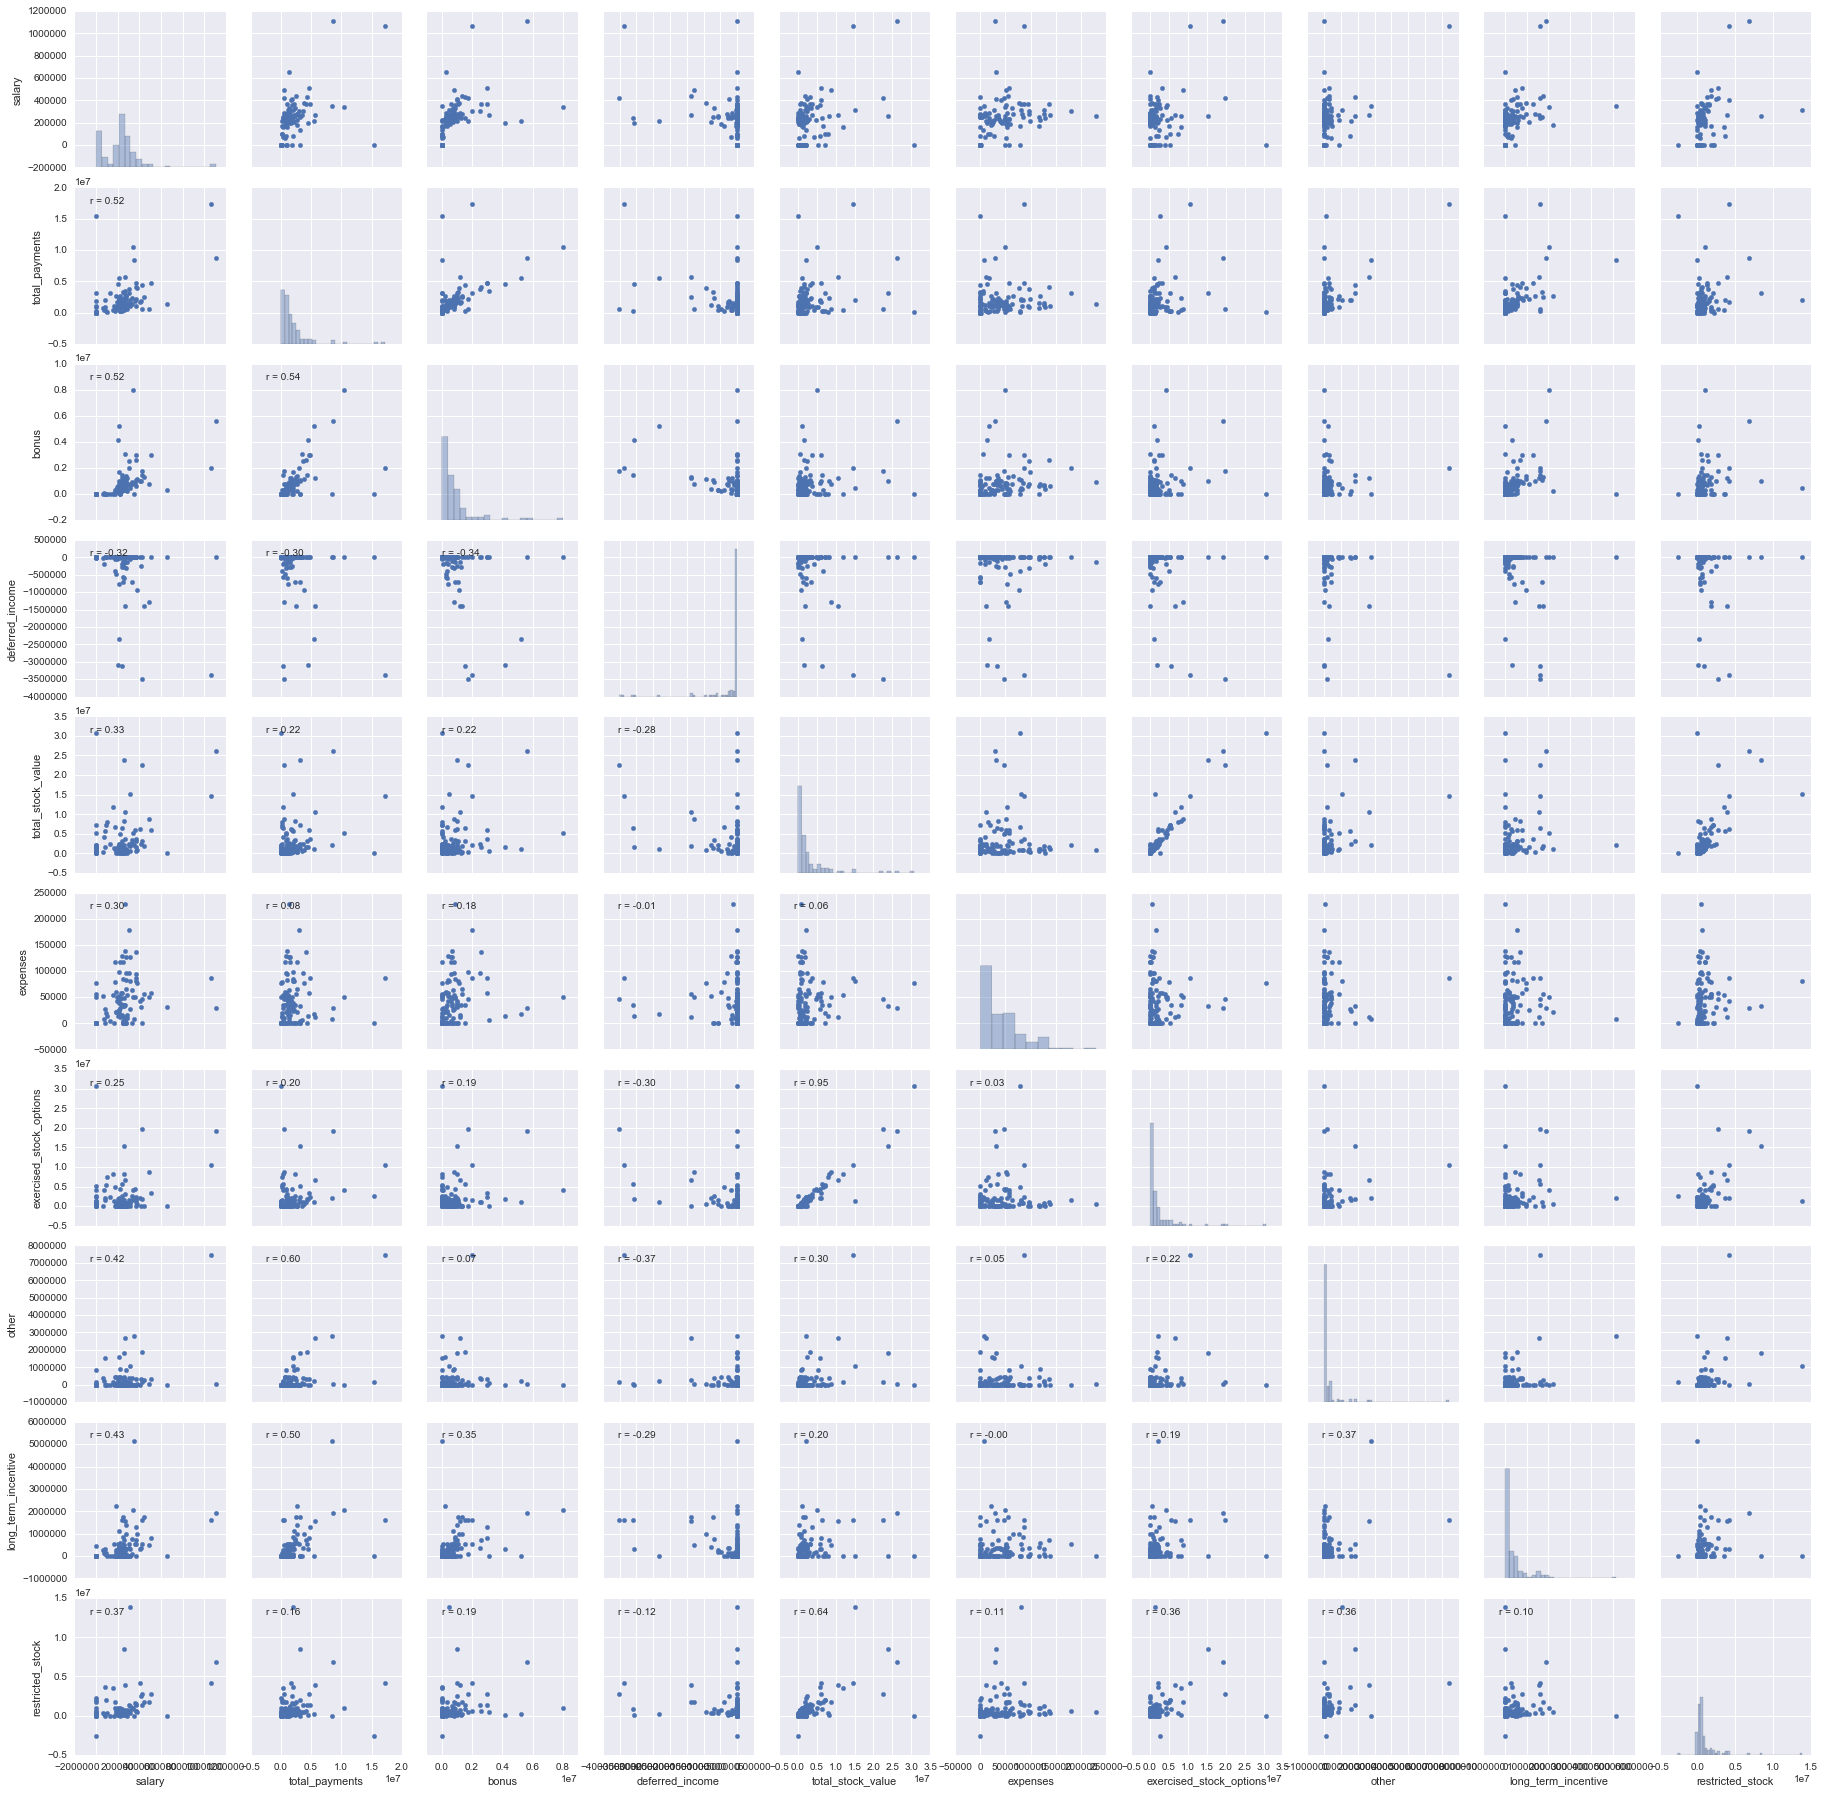

In [21]:
pair_grid(financial_df, "pairgrid_ff.png")

In the notebook it is difficult to see the grid above in detail so we save the plot as a .png file and view it seperately. Upon opening this grid in a seperate file it can be seen that the distributions across the horizontal are generally skewed (which verifys our need to transform the data), there are no more outliers that make the scatter plots unreadable, and there is a very high correlation between the variables total_stock_value and exercised_stock_options.

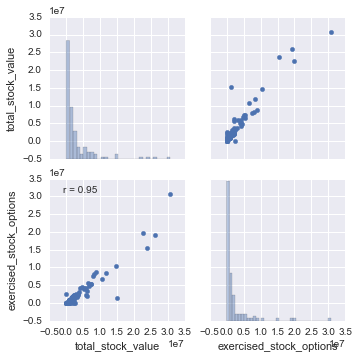

In [30]:
features = ["total_stock_value", "exercised_stock_options"]
pair_grid(financial_df[features], "pairgrid_stocks.png")

Pearson correlation or r-value is a measure of the linear dependence between two variables, i.e. how much of 'Y' is predicted by 'X'. Since the description of thees variables are both regarding enron stocks, and their correlation is close to one, we can see that having both of these variables does not add a great deal of additional information to our model. What it will do is add additional unnecessary weight to the underlying stock feature since the classifier will in effect be seeing an almost identical feature twice. 

Instead of dropping one of the variables arbitrarily we can use principle component analysis (PCA) for dimensionality reduction i.e. combine the two features into one while minimizing information loss. When doing this we will get values that are both positive and negative as PCA works by creating a new origin that is centered in the data where the x-axis is directed along the 'principle axis of variation' (which would be similar to the line created by a linear regression). Since we are going to be doing a log10 transformation on our financial features we won't want any negative values and so I will shift the data such that the minimum value lies on the origin (0).

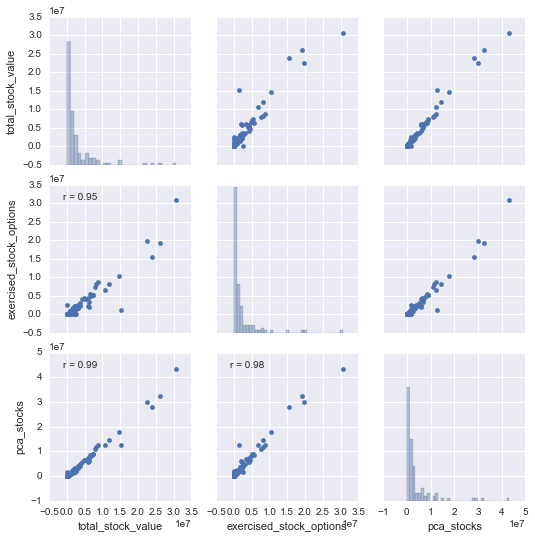

In [31]:
pca = PCA(n_components=1)
stocks = pca.fit_transform(financial_df[features])
stocks = stocks-min(stocks)
financial_df["pca_stocks"] = stocks
#plot new pca stock feature with former stock features
features = ["total_stock_value", "exercised_stock_options", "pca_stocks"]
pair_grid(financial_df[features], "pairgrid_stocks_pca.png")
#drop former stock features
features = ["total_stock_value", "exercised_stock_options"]
financial_df = financial_df.drop(features, 1)

From the pair grid plot above we can see that our new feature, pca_stocks, is a hybrid feature of total_stock_value and exercised_stock_options as can be seen by the respective correlation coefficients (r-values) of 0.99 and 0.98.

With that finished we can now go ahead and take the log10 transformation of the reamining financial features.

In [24]:
def log10(array):
    #adding 1 to the feature data to prevent log10(0)=undefined
    new_array = [x+1 for x in array]
    new_array = np.log10(new_array)
    return new_array

In [32]:
financial_df = financial_df.apply(abs).apply(log10)

The visualization below displays bivariate scatter plots of three of the new transformed features while distinguishing between pois and non-pois. In this plot we can start to make out some clustering of these respective green and blue scatter points.

In [43]:
def boolean_to_string(boolean):
    if boolean == False:
        return "No"
    elif boolean == True:
        return "Yes"
    else:
        return boolean

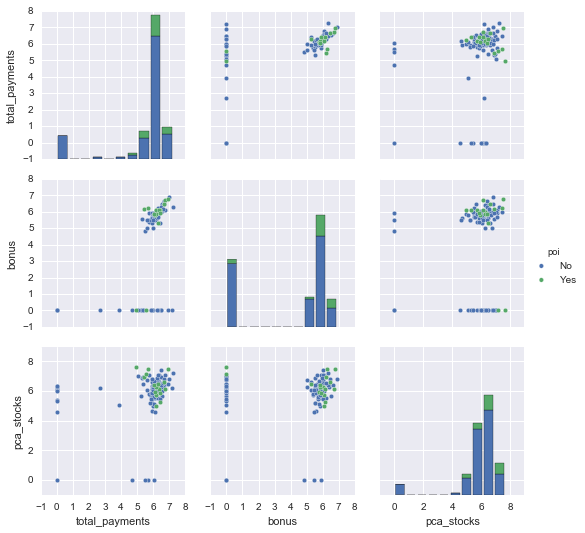

In [47]:
financial_df["poi"] = enron_df["poi"]
#boolean to string is needed so that pairplot won't include poi as a feature
financial_df["poi"] = financial_df["poi"].apply(boolean_to_string)
features = ["total_payments", "bonus", "pca_stocks", "poi"]
sns.pairplot(financial_df[features], hue="poi");

A quick look at the email features show us that the same steps need to be applied. Again, when working through this I would look at the entire feature plot but for the sake of the notebook I will display only select features. 

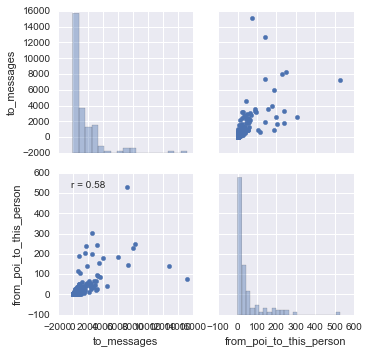

In [50]:
features = ["to_messages", "from_poi_to_this_person"]
pair_grid(email_df[features], "pairgrid_ef.png")

In [ ]:
#log10 transformation of email features
email_df = email_df.apply(log10)
email_df["poi"] = enron_df["poi"]
#boolean to string is needed so that pairplot won't include poi as a feature
email_df["poi"] = email_df["poi"].apply(boolean_to_string)

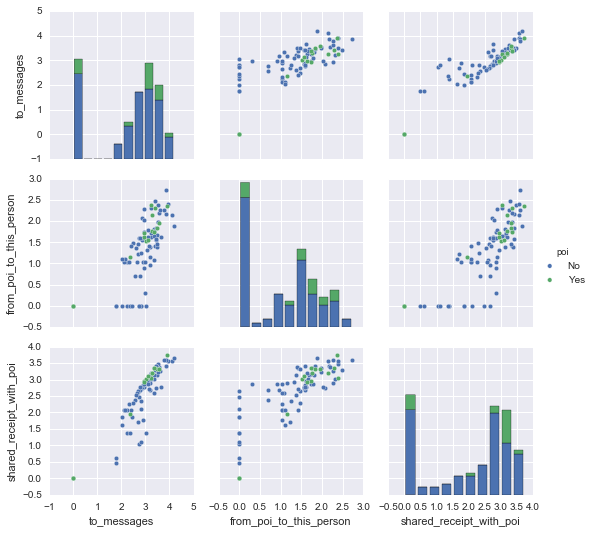

In [59]:
features = ["to_messages", "from_poi_to_this_person", 
            "shared_receipt_with_poi", "poi"]
sns.pairplot(email_df[features], hue="poi");

Before applying the log10 transformation to the entire dataset we need to create a few new features first. When adding features we can use our own human intuition and multiply or divide certain features together if we believe we can derive additional infromation from doing so. Later on in this project we will be using feature selection methods such as SelectKBest which will select the best remaining features and thus we do not have to be concerned at this point if the additional features we create are in fact better than the original ones.

There are two financial features that I would like, the first being bonus over salary, i.e. how many times larger is an employees bonus than their salary. I think this could provide potential insight since an employee that did something illegal or fraudulant might be given a larger bonus as incentive to committing that act. But with this said, bonuses can range quite a bit depending on the person's position and/or seniority and thus the number of times larger a bonus is than the salary gives us a more relative number to go off of. The same thought pattern is true for my second financial feature that I will add which is total stock value over salary.

------
During my first few iterations of this project I had left the data as is but after trying to increase the precision and recall of my classifier I came back to the scatter plots and noticed the left skewed distribution of some of the features. In pursuit of having a more normal distribution of data I decided to log10 all of the financial features.

In [ ]:
def add_one(array):
    new_array = [x+1 for x in array]
    return new_array

In [ ]:
added_ff = pd.DataFrame()
added_ff["bonus/salary"] = financial_df["bonus"] / financial_df["salary"]
added_ff["stock/salary"] = financial_df["total_stock_value"] /\
                                                    financial_df["salary"]
added_ff = added_ff.replace(["inf","-inf", "NaN"], 0)


In [ ]:
added_ff_log10 = added_ff.apply(abs).apply(add_one).apply(np.log10)

In [ ]:
added_ff_sqrt = added_ff.apply(abs).apply(np.sqrt)

In [ ]:
added_ff.hist();

In [ ]:
added_ff_sqrt.hist();

In [ ]:
added_ff_log10.hist();

In [ ]:
added_ff = added_ff.apply(np.sqrt)

In [ ]:
added_ff.apply(np.sqrt)

In [ ]:
added_ff.apply(math.sqrt)

In [ ]:
financial_df.hist(layout=(5,2), xlabelsize=0, ylabelsize=0);

In [ ]:
#no. features remaining
features=total_features(enron_data)
#total number of data points
people=total_people(enron_data)
#allocation across classes (POI/non-POI)
poi=total_classes(enron_data)